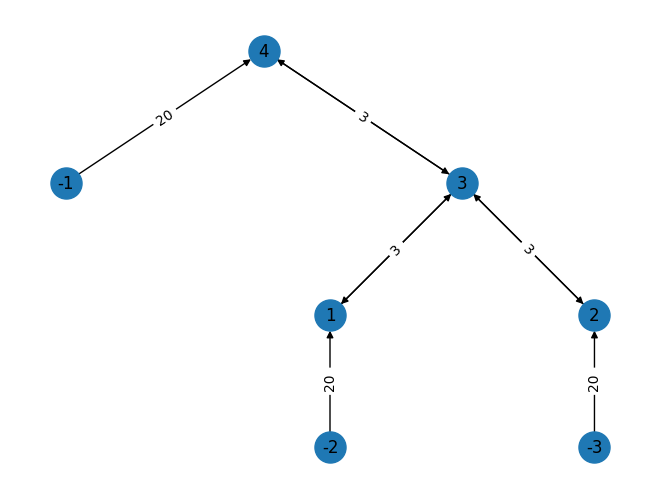

In [1]:
from qutree import *

def parabula(x):
    return np.sum(x**2)

def double_well_2(q):
    x = givens_x(-20.) @ givens_z(10.) @ givens_x(10.) @ q
    #x = q
    v1 = (x[0] - 0.02)**4 - 0.5 * x[0]**2
    v2 = (x[1] - 0.01)**4 - 0.5 * x[1]**2
    v3 = (x[2] - 0.05)**4 - 0.5 * x[2]**2
    return np.exp(-(v1 + v2 + v3))

def double_well(x):
    v1 = 0.5*(x[0]- 0.5)**2 + 0.25 * (x[0] + 0.5)**2
    v2 = 0.5*(x[1]- 0.5)**2 + 0.25 * (x[1] + 0.5)**2
    v3 = 0.5*(x[2]- 0.5)**2 + 0.25 * (x[2] + 0.5)**2
    return np.exp(-(v1 + v2 + v3))

def Err_xyz(x):
    return parabula(x)

def Err_spherical(q):
    x = spherical_to_xyz(q)
    return parabula(x)

N = 20
r = 3
f = 3
#O = Objective(Err_xyz, spherical_linspace(N, include_boundaries= False), spherical_to_xyz)
O = Objective(double_well_2, [linspace(-2., 2., N = N)] * f)
G = balanced_tree(f, r, N)
#G = tt_graph(f, r, N)
G = tn_grid(G, O.linspace)

plot_tree(G)

In [2]:
G_opt, df = ttnopt(G, O, nsweep = 6)
fig = grid_animation(df)
fig.show()

In [3]:
from qutree.ttn.tensor_network import *
edges = [(0, 1), (0, 2), (0, 3)]
ranks = [2, 3, 4]
A = quTensor(np.arange(np.prod(ranks)).reshape(ranks), edges)

B = A.flatten((0, 3))


In [4]:
import numpy as np
e1 = [(-3, 2), (3, 2)]
e2 = [(1, 3), (2, 3), (4, 3)]
edge = (3, 2)
At = np.arange(20*4).reshape((20, 4))
Bt = np.arange(4*6*5).reshape((6, 4, 5))
A = quTensor(At, e1)
B = quTensor(Bt, e2)

#C2 = np.tensordot(At, Bt, axes=([1], [1]))
C2 = np.einsum(At,[0, 1], Bt, [2, 1, 3], [0, 2, 3])
C = tensordot(A, B, edge)
print(C.edges, C.shape, C2.shape)
print(np.allclose(C2, C))

D = B.flatten((2, 3))
print(D.shape, D.edges)



[(-3, 2)] [(1, 3), (3, 4)]
swapping (-3, 2) , new edge:  (-3, 3)
[(-3, 3), (1, 3), (3, 4)] (20, 6, 5) (20, 6, 5)
True
(30, 4) [((1, 3), (3, 4)), (2, 3)]


In [5]:
e1 = [(3, 2), (2, 3)]
e2 = [(1, 3), (2, 3), (3, 4)]
edge = (2, 3)
matt = np.arange(4*4).reshape((4, 4))
At = np.arange(4*6*5).reshape((6, 4, 5))

mat = quTensor(matt, e1)
A = quTensor(At, e2)

B = tensordot(mat, A, edge)
print(B.edges, B.shape)

[(2, 3)] [(1, 3), (3, 4)]
[(2, 3), (1, 3), (3, 4)] (4, 6, 5)


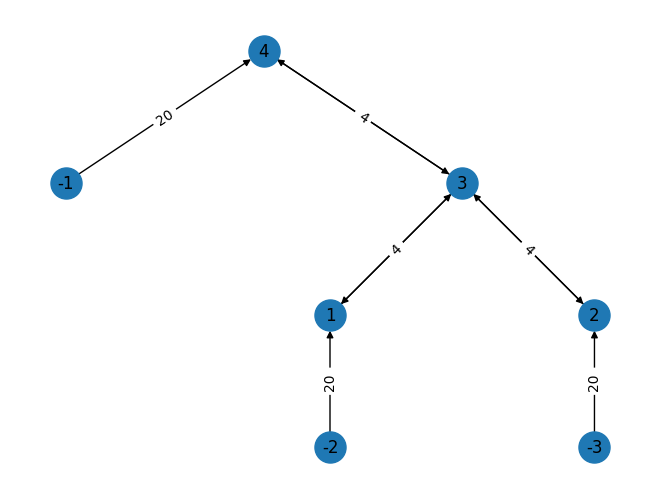

In [6]:
G = balanced_tree(3, 4, 20)
plot_tree(G)

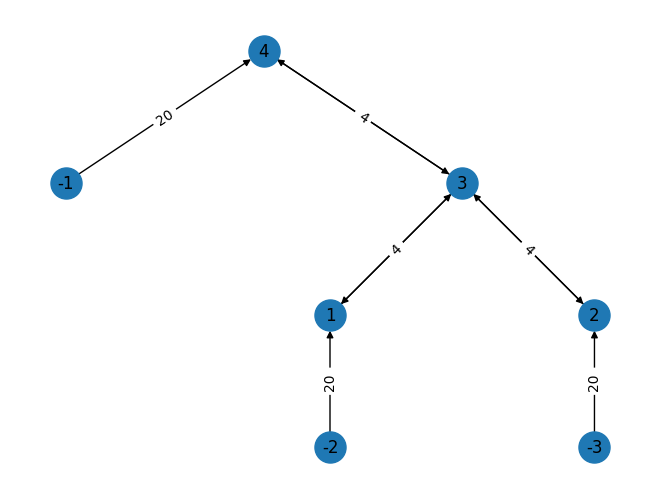

In [7]:
# test for removing edges manually
#G = remove_edge(G, (1, 3))
#G = remove_edge(G, (2, 3))
#G = remove_edge(G, (3, 4))
#plot_tree(G)
F = G.copy()
for edge in sweep(F):
    if is_leaf(edge):
        continue
    if edge[0] > edge[1]:
        break # only up-sweep
    # contract lower into upper tensor
#    A = G.nodes[edge[0]]
#    B = G.nodes[edge[1]]
    F = remove_edge(F, edge)

plot_tree(G)

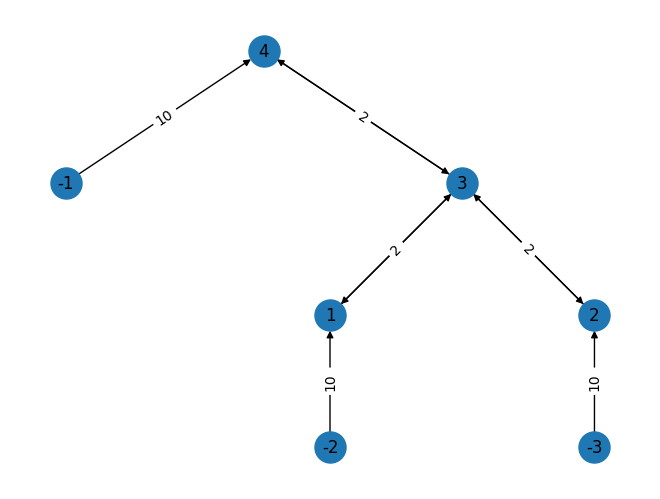

In [8]:
tn = balanced_tree(3, 2, 10)
plot_tree(tn)

In [9]:
# cool multi-D plot
#import pandas as pd
#import numpy as np
#
#import matplotlib.pyplot as plt
#
#from sklearn.datasets import load_iris, load_boston, load_wine
#from sklearn.preprocessing import MinMaxScaler
#
#import plotly.express as px
#import plotly.graph_objects as go
#
#boston_df = load_boston()
#
#%matplotlib inline
#cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
#       'PTRATIO', 'B', 'LSTAT',]
#
#fig = go.Figure(data=
#    go.Parcoords(
#        line = dict(color = boston_df['HousePrice'],
#                   colorscale = px.colors.sequential.Blues,
#                   cmin=25, cmax=50),
#        dimensions = [dict(label=col, values=boston_df[col]) for col in cols]
#    )
#)
#
#fig.update_layout(
#    title="Boston House Price Coordinates Plot"
#)
#
#fig.show()